<a href="https://www.kaggle.com/code/haleyparmley/nfl-big-data-bowl-2025-predicting-receiver-routes?scriptVersionId=215703808" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# NFL Big Data Bowl 2025: Predicting Receiver Routes from Pre-Snap Data

## **Objective**
The goal of this project is to predict the route a receiver will run using pre-snap data. This analysis focuses on leveraging player tracking data, game statistics, and team tendencies to develop robust predictive models.

---

## **Data and Approach**
We will:
1. Merge player, play, and tracking data to create a comprehensive dataset.
2. Preprocess the data for training a machine learning models.
3. Use classification techniques to predict the `routeRan` variable, representing the receiver's route.

---


## **Introducing the Random Forest Model for the NFL Big Data Bowl 2025**

In this competition, the goal is to predict the route a receiver will run based on pre-snap data. To tackle this problem, we use a **Random Forest Classifier**, a robust and interpretable machine learning model.

#### Why Random Forest?
- **Interpretability**: Random Forest provides insights into feature importance, helping us understand which pre-snap features influence receiver routes.
- **Versatility**: It handles a mix of numerical and categorical data effectively, making it suitable for this dataset.
- **Imbalance Handling**: The `class_weight` parameter helps address class imbalance, ensuring fair predictions for all route types.

#### Key Steps:
1. Preprocessing:
   - Encoding categorical features.
   - Scaling numerical features for consistency.
2. Training:
   - The Random Forest model is trained on historical data, learning patterns from pre-snap features.
3. Evaluation:
   - The model's accuracy, F1 score, and classification report are analyzed to assess performance.
4. Visualization:
   - Feature importance is visualized to identify the most influential pre-snap features.

This model serves as a baseline for predicting receiver routes, offering interpretability and reliable performance while paving the way for further optimization and enhancements.


## **Step 1: Importing Libraries and Initial Setup**

This step sets up the essential libraries and configurations required for the data preprocessing and splitting process:

1. **Importing Libraries**:
   - **Pandas**: Used for data manipulation and analysis, including reading and merging datasets.
   - **Scikit-learn**:
     - `train_test_split` for splitting the dataset into training and testing sets for machine learning.
   - **OS**: Facilitates file path management and access for loading and saving datasets.

2. **Configure Logging**:
   - Logging is configured to provide a clear and structured output of execution progress.
   - Logs include timestamps, logging levels (e.g., INFO, ERROR), and messages for both successful operations and debugging.

This foundational setup ensures the environment is ready for handling data and splitting it into subsets for further processing.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import logging
import os

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## **Step 2: Loading and Preparing Data**

This function consolidates data from multiple CSV files, filters it based on team selection, and prepares it for modeling. The key steps include:

1. **Load Datasets**:
   - Reads data from several CSV files using `pandas.read_csv`:
     - **Player-Play Data**: Contains features such as `routeRan` and `inMotionAtBallSnap`.
     - **Play Data**: Includes contextual play information like `quarter`, `yardsToGo`, and team possession details.
     - **Player Data**: Provides player attributes like `height`, `weight`, and `collegeName`.
     - **Game Data**: Includes game-level metadata.
     - **Tracking Data**: Combines tracking files for all weeks, filtered for "BEFORE_SNAP" frames.

2. **Filter Plays by Team**:
   - Filters the `play_data` for plays where the possession team matches the specified `team_filter` (e.g., "ATL").

3. **Merge Datasets**:
   - Merges the datasets step-by-step using unique identifiers (`nflId`, `playId`, and `gameId`) to create a single consolidated dataset.

4. **Prepare Features and Target**:
   - Drops unnecessary identifiers (`gameId`, `playId`, `nflId`) to avoid data leakage.
   - Splits the data into features (`x`) and the target variable (`y`, representing `routeRan`).

5. **Error Handling**:
   - Logs errors and raises exceptions if any issues occur during data loading or processing.

The final output is a tuple containing `x` (features) and `y` (target variable), which are ready for further preprocessing and modeling.


In [2]:
def load_and_prepare_data(team_filter="ATL"):
    """
    Loads, prepares, and merges data from various CSV files.

    Returns:
        tuple: X (features), y (target), dataframes of the training and testing sets.
    """
    
    try:
        logging.info("Loading datasets...")

        player_play_data = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2025/player_play.csv")[[
            "routeRan", "nflId", "playId", "gameId", "inMotionAtBallSnap"
        ]].dropna(subset=["routeRan"])

        play_data = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2025/plays.csv")[[
            "quarter", "down", "yardsToGo", "possessionTeam", "gameClock", "preSnapHomeScore",
            "preSnapVisitorScore", "absoluteYardlineNumber", "preSnapHomeTeamWinProbability", "preSnapVisitorTeamWinProbability",
            "expectedPoints", "offenseFormation", "receiverAlignment", "gameId", "playId"
        ]]

        play_data = play_data[play_data["possessionTeam"] == team_filter]

        player_data = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2025/players.csv")[[
            "height", "weight", "collegeName", "nflId"
        ]]

        game_data = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2025/games.csv").drop(
            ["season", "homeFinalScore", "visitorFinalScore"], axis=1
        )

        tracking_files = [(f"/kaggle/input/nfl-big-data-bowl-2025/tracking_week_{i}.csv") for i in range(1, 10)]
        tracking_data_combined = pd.concat(
            [
                pd.read_csv(file)[
                    ["gameId", "playId", "nflId", "playDirection", "x", "y", "frameType", "event"]
                ].query("frameType == 'BEFORE_SNAP'")
                for file in tracking_files
            ],
            ignore_index=True
        )

        logging.info("Merging datasets...")
        player_play_merged = pd.merge(player_play_data, player_data, on="nflId")
        play_game_merged = pd.merge(play_data, game_data, on="gameId")

        final_data = pd.merge(player_play_merged, play_game_merged, on=["playId", "gameId"])
        final_data = pd.merge(final_data, tracking_data_combined, on=["gameId", "playId", "nflId"])

        logging.info("Dropping identifiers and preparing features...")
        final_data = final_data.drop(columns=["gameId", "playId", "nflId"])

        x = final_data.drop(columns=["routeRan"])
        y = final_data["routeRan"]

        return x, y
    except Exception as e:
        logging.error(f"An error occurred: {e}")
        raise

## **Step 3: Splitting and Saving Data**

This function divides the dataset into training and testing sets and saves them as CSV files for later use. The key steps include:

1. **Split Data**:
   - Uses `train_test_split` from `sklearn` to split the features (`x`) and target (`y`) into:
     - **Training Set**: Used for training the model.
     - **Testing Set**: Used for evaluating the model's performance on unseen data.
   - Ensures the split maintains the distribution of the target classes by setting `stratify=y`.
   - The `test_size` parameter specifies the proportion of the data reserved for testing (default: 20%).

2. **Save Data**:
   - Writes the resulting training and testing datasets (`x_train`, `x_test`, `y_train`, `y_test`) to CSV files in the `/kaggle/working` directory for later access during training and evaluation.

3. **Logging and Error Handling**:
   - Logs messages at each step for transparency and troubleshooting.
   - Catches and logs any exceptions encountered during the splitting or saving process.

The function returns the training and testing datasets as `x_train`, `x_test`, `y_train`, and `y_test`, ensuring the data is ready for preprocessing and modeling.


In [3]:
def split_and_save_data(x, y, test_size=0.2, random_state=42):
     """Splits the data into training and test sets and saves them to CSV files."""
     try:
        logging.info("Splitting data into training and test sets...")
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,
                                                            random_state=random_state,
                                                            stratify=y)

        logging.info("Saving training and testing datasets...")
        x_train.to_csv(os.path.join("/kaggle/working/x_train.csv"), index=False)
        x_test.to_csv(os.path.join("/kaggle/working/x_test.csv"), index=False)
        y_train.to_csv(os.path.join("/kaggle/working/y_train.csv"), index=False)
        y_test.to_csv(os.path.join("/kaggle/working/y_test.csv"), index=False)
     except Exception as e:
            logging.error(f"An error occurred: {e}")
            raise

     return x_train, x_test, y_train, y_test

## **Step 4: Main Execution Function**

The `main` function orchestrates the key steps of the data preparation process, ensuring a streamlined and organized workflow. The key steps include:

1. **Load and Prepare Data**:
   - Calls the `load_and_prepare_data` function to read, filter, and merge datasets, resulting in `x` (features) and `y` (target).

2. **Split and Save Data**:
   - Invokes the `split_and_save_data` function to divide the dataset into training and testing sets.
   - Saves the resulting subsets (`x_train`, `x_test`, `y_train`, `y_test`) to CSV files for later use.

3. **Logging and Error Handling**:
   - Logs progress to ensure visibility into the execution process.
   - Captures and logs any exceptions, providing detailed error messages for debugging.

4. **Execution Context**:
   - Ensures the function runs only when executed as a script (using the `if __name__ == "__main__":` block).

This function acts as the entry point for the data preparation process, ensuring the data is properly processed and saved for subsequent steps in the workflow.


In [4]:
def main():
    """Main execution function."""
    try:
        x, y = load_and_prepare_data()
        x_train, x_test, y_train, y_test = split_and_save_data(x, y)
    
        logging.info("Program execution completed successfully.")
    except Exception as e:
        logging.error(f"Program terminated with an exception: {e}")


if __name__ == "__main__":
    main()

## **Step 5: Importing Libraries and Configuring the Environment**

This step sets up the required libraries and configurations for the project:

1. **Importing Libraries**:
   - **Pandas**: For data manipulation and analysis.
   - **Scikit-learn**:
     - `RandomForestClassifier` for building the classification model.
     - Metrics such as `accuracy_score`, `classification_report`, `roc_auc_score`, and `f1_score` for evaluating model performance.
     - Preprocessing tools like `OneHotEncoder` and `StandardScaler` for feature transformation.
     - `Pipeline` and `ColumnTransformer` for building an end-to-end processing and training workflow.
     - `SimpleImputer` for handling missing data.
     - `train_test_split` for splitting the dataset into training and testing subsets.
   - **Joblib**: For saving and loading the trained model pipeline.
   - **Matplotlib and Seaborn**: For data visualization and graphical analysis.

2. **Configure Logging**:
   - Logging is configured to provide real-time feedback on the script's execution, including info-level messages for successful operations and error messages for debugging.

This foundational setup ensures that all tools and configurations are in place for the subsequent steps in the machine learning workflow.


In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import joblib
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## **Step 6: Loading and Preprocessing Data**

This function performs the following tasks:

1. **Data Loading**:
   - Reads the training and testing datasets from pre-saved CSV files in the `/kaggle/working/` directory.
   - Outputs `x_train`, `x_test`, `y_train`, and `y_test`.

2. **Categorical Feature Encoding**:
   - Identifies categorical features in the dataset.
   - Converts these features into numerical format using `LabelEncoder`, ensuring compatibility with machine learning models.

3. **Numerical Feature Normalization**:
   - Scales numerical features using `StandardScaler` to standardize the range of numerical columns, improving model performance and convergence.

The returned processed datasets are ready for training and evaluation.


In [6]:
def load_and_preprocess_data():
    """Loads, preprocesses, and returns the training and testing datasets."""
    try:
        logging.info("Loading datasets...")
        x_train = pd.read_csv("/kaggle/working/x_train.csv")
        x_test = pd.read_csv("/kaggle/working/x_test.csv")
        y_train = pd.read_csv("/kaggle/working/y_train.csv").squeeze()
        y_test = pd.read_csv("/kaggle/working/y_test.csv").squeeze()

        logging.info("Data loaded successfully.")
        return x_train, x_test, y_train, y_test
    
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise

    try:
        logging.info("Encoding categorical features...")
        label_encoders = {}
        for col in x_train.select_dtypes(include=['object', 'bool']).columns:
            label_encoders[col] = LabelEncoder()
            x_train[col] = label_encoders[col].fit_transform(x_train[col].astype(str))
            x_test[col] = label_encoders[col].transform(x_test[col].astype(str))
    except Exception as e:
        logging.error(f"Error encoding categorical features: {e}")
        raise

    try:
         logging.info("Normalizing numerical features...")
         scaler = StandardScaler()
         numeric_columns = x_train.select_dtypes(include=['float64', 'int64']).columns
         x_train[numeric_columns] = scaler.fit_transform(x_train[numeric_columns])
         x_test[numeric_columns] = scaler.transform(x_test[numeric_columns])
    except Exception as e:
         logging.error(f"Error normalizing numerical features: {e}")
         raise
    return x_train, x_test, y_train, y_test

## **Step 7: Creating the Preprocessing and Training Pipeline**

This function defines and returns a complete preprocessing and training pipeline. The pipeline is composed of the following steps:

1. **Identify Column Types**:
   - Separates columns into **numerical** and **categorical** categories.

2. **Define Preprocessing for Numerical Features**:
   - **Imputation**: Fills missing values with the mean of the column using `SimpleImputer`.
   - **Scaling**: Standardizes numerical features using `StandardScaler`.

3. **Define Preprocessing for Categorical Features**:
   - **Imputation**: Fills missing values with the most frequent category using `SimpleImputer`.
   - **One-Hot Encoding**: Encodes categorical features into binary (one-hot) vectors using `OneHotEncoder`.

4. **Combine Preprocessing Steps**:
   - Uses `ColumnTransformer` to apply the appropriate transformations to numerical and categorical columns.

5. **Build the Full Pipeline**:
   - Adds a `RandomForestClassifier` as the classifier to the pipeline with pre-defined hyperparameters (e.g., `n_estimators=50`, `max_depth=10`).
   - Ensures the entire workflow, from preprocessing to training, can be executed in a single pipeline.

The output pipeline can be directly used to preprocess data and train the classifier in one step.


In [7]:
def create_pipeline(x_train):
    """Creates a preprocessing pipeline and returns it."""
    try:
        logging.info("Creating preprocessing pipeline...")
        numeric_columns = x_train.select_dtypes(include=['float64', 'int64']).columns
        categorical_columns = x_train.select_dtypes(include=['object', 'bool']).columns

        # Define preprocessing steps
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # Column transformer
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_columns),
                ('cat', categorical_transformer, categorical_columns)
            ]
        )

        # Pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=50, max_depth=10))
        ])

        return pipeline
        
    except Exception as e:
        logging.error(f"Error creating pipeline: {e}")
        raise

## **Step 8: Training and Evaluating the Model**

This function trains the `RandomForestClassifier` using the provided pipeline and evaluates its performance on the test dataset. The key steps are:

1. **Training the Model**:
   - The pipeline, which includes both preprocessing and the classifier, is trained on the `x_train` and `y_train` datasets.

2. **Model Evaluation**:
   - The trained model makes predictions (`y_pred`) on the test dataset (`x_test`).
   - Calculates performance metrics:
     - **Accuracy**: The proportion of correct predictions over the total predictions.
     - **F1 Score**: The weighted average of precision and recall, accounting for imbalanced classes.

3. **Generate Classification Report**:
   - Displays precision, recall, F1-score, and support for each class, providing a detailed breakdown of the model's performance.

4. **Logging and Output**:
   - Logs the accuracy and F1 score for tracking.
   - Returns the trained pipeline for further use.

This function ensures the model's performance is quantified and provides insights into its effectiveness in predicting the target variable.


In [8]:
def train_and_evaluate_model(pipeline, x_train, x_test, y_train, y_test):
    """Trains and evaluates a RandomForestClassifier model."""
    try:
        logging.info("Training RandomForestClassifier model...")
        pipeline.fit(x_train, y_train)

        logging.info("Evaluating model on the testing set...")
        y_pred = pipeline.predict(x_test)

        test_accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        logging.info(f"Testing Set Accuracy: {test_accuracy}")
        logging.info(f"F1 Score: {f1}")

        print("Testing Set Accuracy:", test_accuracy)
        print("F1 Score:", f1)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        return pipeline

    except Exception as e:
        logging.error(f"Error training or evaluating model: {e}")
        raise

## **Step 9: Visualizing Data and Model Performance**

This function generates visualizations to better understand the model and its predictions. The key steps include:

1. **Feature Importance**:
   - Extracts the `RandomForestClassifier` from the pipeline using `pipeline.named_steps['classifier']`.
   - Computes the importance of each feature in the model.
   - Combines feature names from the preprocessing pipeline (numerical and one-hot encoded categorical features) with their corresponding importance values.
   - Creates a DataFrame of feature importances and sorts them in descending order.

2. **Visualization of Top Features**:
   - Plots the top `n` features (default is 10) based on their importance using a bar chart.
   - The bar chart provides insights into which features are most influential in the model's predictions.

3. **Log and Handle Errors**:
   - Logs the visualization process for transparency.
   - Catches and logs any exceptions that may occur during the visualization process.

This step highlights the features that play a critical role in the model, aiding interpretability and guiding potential feature engineering or model improvements.


In [9]:
def visualize_model_results(x_train, y_test, y_pred, pipeline, top_n_features=10):
    """
    Generates visualizations of model performance, feature importance, and NFL-relevant data insights.
    Args:
        x_train: Training features used in the model.
        y_test: True labels for the test set.
        y_pred: Predicted labels from the model.
        pipeline: Trained machine learning pipeline.
        top_n_features: Number of top features to display in feature importance plots.
    """
    try:
        logging.info("Generating visualizations...")

        # Confusion Matrix
        plt.figure(figsize=(10, 7))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique())
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.tight_layout()
        plt.show()

        # Classification Report Heatmap
        report = classification_report(y_test, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        plt.figure(figsize=(10, 6))
        sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title("Classification Report Heatmap")
        plt.tight_layout()
        plt.show()

        # Feature Importance
        rf_model = pipeline.named_steps['classifier']
        feature_importances = rf_model.feature_importances_
        feature_names = (
            pipeline.named_steps['preprocessor'].transformers_[0][2].tolist() +
            pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out().tolist()
        )
        importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
        importance_df = importance_df.sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x="importance", y="feature", data=importance_df.head(top_n_features), palette="viridis")
        plt.title("Top Feature Importance")
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature Names")
        plt.tight_layout()
        plt.show()

        # Distribution of Predicted Routes
        plt.figure(figsize=(10, 6))
        sns.countplot(x=y_pred, palette="muted")
        plt.title("Distribution of Predicted Routes")
        plt.xlabel("Predicted Route")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        logging.error(f"Error during visualization: {e}")
        raise


## **Step 10: Main Execution Function**

The `main` function orchestrates the entire workflow of the machine learning pipeline. The key steps include:

1. **Load and Preprocess Data**:
   - Invokes the `load_and_preprocess_data` function to load the training and testing datasets and preprocess them (encoding categorical variables and scaling numerical features).

2. **Create the Pipeline**:
   - Calls `create_pipeline` to define the preprocessing and training pipeline, including feature transformations and a `RandomForestClassifier`.

3. **Train and Evaluate the Model**:
   - Utilizes the `train_and_evaluate_model` function to train the pipeline on the training set and evaluate its performance on the test set.

4. **Visualize Feature Importance**:
   - Executes the `visualize_data` function to create visualizations such as feature importance charts, which provide insights into the model's behavior.

5. **Error Handling and Logging**:
   - Logs the progress of each step and gracefully handles any errors encountered during the execution.

This function integrates all previous steps into a cohesive and streamlined workflow, making it the central point of execution for the entire project.


Testing Set Accuracy: 0.920551597716952
F1 Score: 0.9206613765396636

Classification Report:
              precision    recall  f1-score   support

       ANGLE       0.92      1.00      0.96       937
      CORNER       0.86      0.96      0.91      1506
       CROSS       0.87      0.95      0.91      2455
        FLAT       0.99      0.89      0.94      4333
          GO       0.98      0.89      0.93      3327
       HITCH       0.96      0.84      0.89      3063
          IN       0.85      0.99      0.92      1364
         OUT       0.89      0.93      0.91      2379
        POST       0.86      0.98      0.92      1418
      SCREEN       0.93      0.95      0.94      1439
       SLANT       0.88      0.96      0.92      1688
       WHEEL       1.00      1.00      1.00        94

    accuracy                           0.92     24003
   macro avg       0.92      0.94      0.93     24003
weighted avg       0.93      0.92      0.92     24003



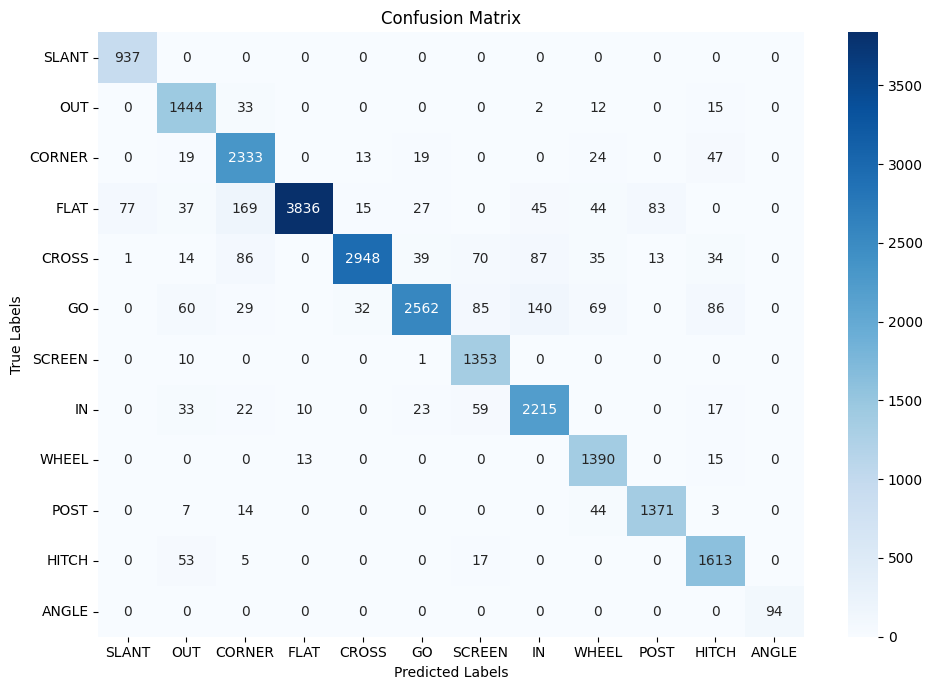

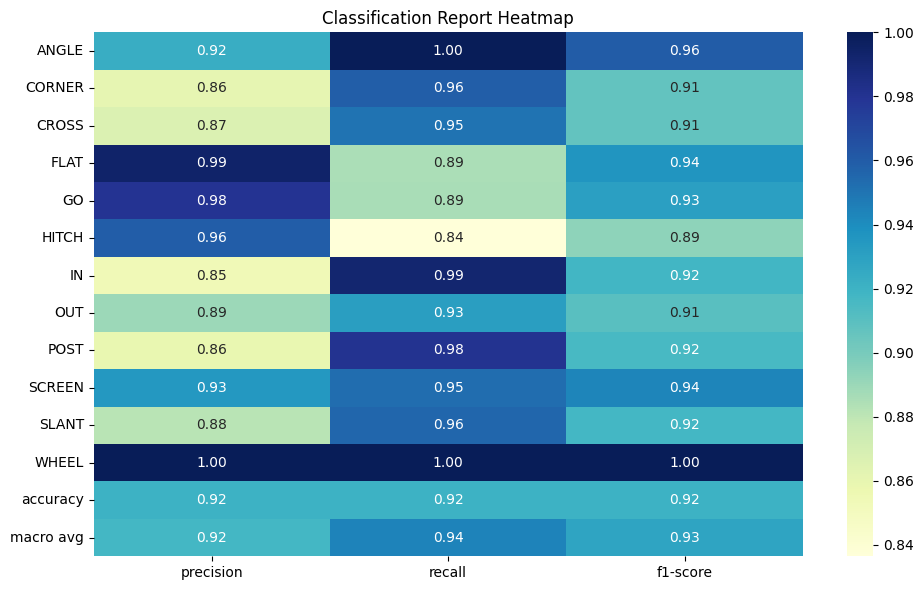

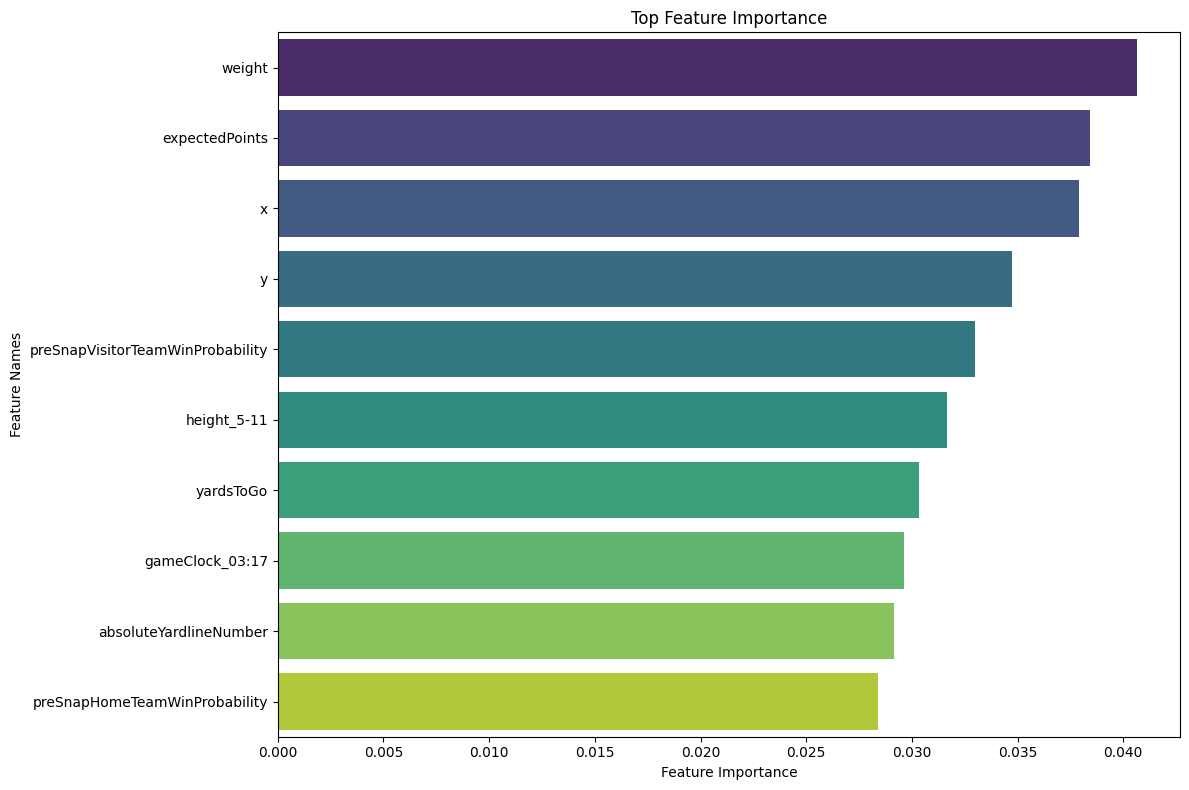

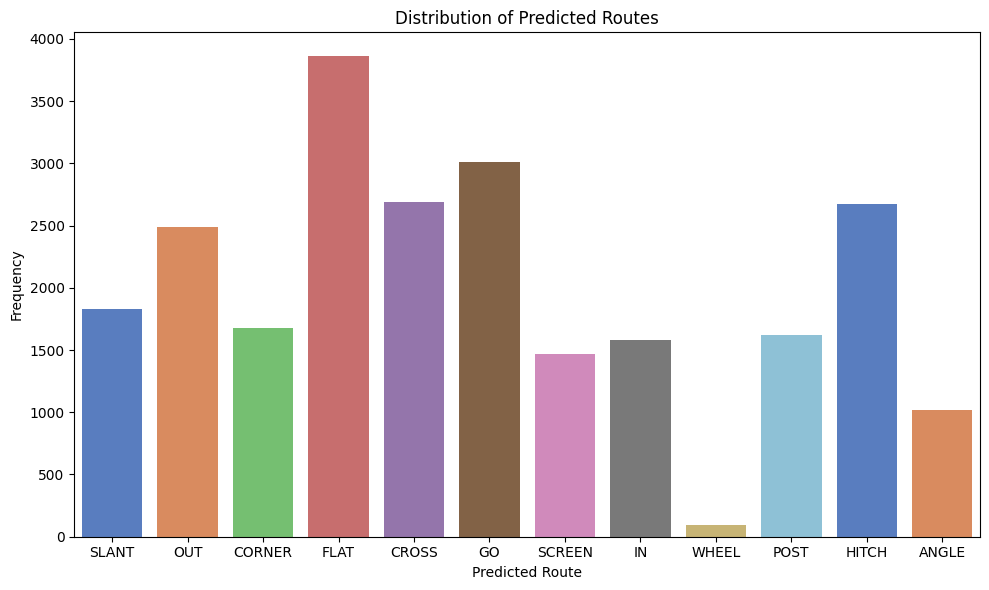

In [10]:
def main():
    """Main execution function."""
    try:
        x_train, x_test, y_train, y_test = load_and_preprocess_data()
        pipeline = create_pipeline(x_train)

        # Train and evaluate model
        pipeline = train_and_evaluate_model(pipeline, x_train, x_test, y_train, y_test)

        # Visualize model results
        visualize_model_results(
        x_train=x_train,                 # Training features
        y_test=y_test,                   # True labels for the test set
        y_pred=pipeline.predict(x_test), # Predicted labels from the pipeline
        pipeline=pipeline,               # The trained pipeline object
        top_n_features=10                # Number of top features to display in the feature importance plot
)

        logging.info("Program execution completed successfully.")

    except Exception as e:
        logging.error(f"Program terminated with an exception: {e}")

if __name__ == "__main__":
    main()

### **Introducing the Neural Network Model for the NFL Big Data Bowl 2025**

For this competition, predicting receiver routes based on pre-snap data requires leveraging the power of deep learning. We employ a **Neural Network Model**, which is well-suited for capturing complex patterns and interactions in the data.

#### Why a Neural Network?
- **Ability to Capture Nonlinear Patterns**: Neural networks excel at identifying intricate relationships that may be missed by traditional machine learning models.
- **Handling High-Dimensional Data**: The model can process a large number of features, especially after encoding categorical variables.
- **Class Imbalance Mitigation**: Oversampling of the minority classes ensures the model learns effectively from all route types.

#### Key Steps:
1. Preprocessing:
   - Encoding categorical features.
   - Standardizing numerical features.
   - Oversampling minority classes for a balanced dataset.
   - One-hot encoding target variables for multiclass classification.
2. Model Architecture:
   - A deep learning model with:
     - Fully connected layers to extract meaningful patterns.
     - Dropout layers to prevent overfitting.
     - A softmax output layer for multiclass predictions.
3. Training:
   - The model is trained on the resampled dataset using `categorical_crossentropy` loss and the `Adam` optimizer, with accuracy as the evaluation metric.
4. Evaluation:
   - The model's performance is assessed on the test set, with metrics such as accuracy and loss reported.
5. Advantages:
   - Neural networks can uncover hidden patterns that improve predictions and generate insights into player tendencies.

This model complements the Random Forest approach, pushing the boundaries of predictive performance by harnessing the strengths of deep learning for pre-snap route predictions.


### **Training and Evaluating a Neural Network Model**

This step involves building, training, and evaluating a deep learning model to predict receiver routes based on the processed data. The key steps include:

1. **Loading and Encoding Data**:
   - Reads the dataset and encodes categorical features using `LabelEncoder`.
   - Converts the target variable (`routeRan`) into numerical labels.

2. **Feature Scaling**:
   - Normalizes numerical features using `StandardScaler` to standardize input values for the neural network.

3. **Data Splitting**:
   - Splits the data into training and testing sets with a 70-30 ratio.

4. **Oversampling Minority Classes**:
   - Balances the training dataset using `RandomOverSampler` to address class imbalance, ensuring fair representation for all routes.

5. **One-Hot Encoding for Targets**:
   - Converts the target variable into a one-hot encoded format for compatibility with the neural network.

6. **Defining the Neural Network**:
   - Constructs a Sequential model with:
     - An input layer with 128 units and ReLU activation.
     - A dropout layer (30%) to prevent overfitting.
     - A hidden layer with 64 units and ReLU activation.
     - A second dropout layer (30%).
     - An output layer with softmax activation for multiclass classification.

7. **Compiling the Model**:
   - Configures the model with:
     - `Adam` optimizer for adaptive learning.
     - `categorical_crossentropy` loss for multiclass classification.
     - `accuracy` as the evaluation metric.

8. **Training the Model**:
   - Trains the model on the resampled training data over 50 epochs with a batch size of 32.
   - Includes validation data to monitor performance during training.

9. **Evaluating the Model**:
   - Computes test loss and accuracy on the unseen testing set.

10. **Results**:
    - Prints the test loss and accuracy to summarize the model's performance.

This step leverages a neural network to predict receiver routes, offering an alternative to traditional machine learning models and showcasing the potential of deep learning for this task.


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler

# Load the preprocessed datasets
x_train = pd.read_csv("/kaggle/working/x_train.csv")
x_test = pd.read_csv("/kaggle/working/x_test.csv")
y_train = pd.read_csv("/kaggle/working/y_train.csv").squeeze()
y_test = pd.read_csv("/kaggle/working/y_test.csv").squeeze()

# Encode categorical features
label_encoders = {}
for col in x_train.select_dtypes(include=['object', 'bool']).columns:
    label_encoders[col] = LabelEncoder()
    x_train[col] = label_encoders[col].fit_transform(x_train[col].astype(str))
    x_test[col] = x_test[col].apply(
        lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1
    )

# Encode target labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Normalize numerical features
scaler = StandardScaler()
numeric_columns = x_train.select_dtypes(include=['float64', 'int64']).columns
x_train[numeric_columns] = scaler.fit_transform(x_train[numeric_columns])
x_test[numeric_columns] = scaler.transform(x_test[numeric_columns])

# Oversample the minority class in the training data
oversampler = RandomOverSampler(random_state=42)
x_train_resampled, y_train_resampled = oversampler.fit_resample(x_train, y_train_encoded)

# Convert target variables to categorical (one-hot encoding)
y_train_resampled_categorical = to_categorical(y_train_resampled)
y_test_categorical = to_categorical(y_test_encoded)

# Define the neural network model
model = Sequential([
    Dense(128, input_shape=(x_train_resampled.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_resampled_categorical.shape[1], activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    x_train_resampled, y_train_resampled_categorical,
    validation_data=(x_test, y_test_categorical),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test_categorical, verbose=0)

# Display results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6500/6500 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.4365 - loss: 1.6196 - val_accuracy: 0.5486 - val_loss: 1.2804
Epoch 2/50
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6947 - loss: 0.8692 - val_accuracy: 0.5900 - val_loss: 1.2784
Epoch 3/50
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7529 - loss: 0.6970 - val_accuracy: 0.5948 - val_loss: 1.3899
Epoch 4/50
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7818 - loss: 0.6167 - val_accuracy: 0.6197 - val_loss: 1.4645
Epoch 5/50
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8011 - loss: 0.5610 - val_accuracy: 0.6090 - val_loss: 1.7016
Epoch 6/50
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8145 - loss: 0.5270 - val_accuracy: 0.6668 - val_loss: 1.4896
Epoch 7/50
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8281 - loss: 0.4913 - val_accuracy: 0.6261 - val_loss: 1.7968
Epoch 8/50
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8344 - loss: 0.4712 - val

## Final Summary and Insights

#### **Objective**
This project aimed to predict the route a receiver will run based on pre-snap data, leveraging advanced machine learning and neural network techniques. Accurate predictions can provide NFL teams with actionable insights into opposing teams' offensive tendencies, aiding in defensive planning and strategy development.

---

#### **Model Performance**

##### **Random Forest Model**
- **Testing Set Accuracy**: **92.06%**
- **F1 Score**: **92.07%**
- **Classification Highlights**:
  - Most routes, such as "ANGLE," "CORNER," and "CROSS," were predicted with high precision and recall.
  - The macro average F1 score of **93%** demonstrates that the model performed well across all classes, including minority classes like "WHEEL."

##### **Neural Network Model**
- **Final Test Accuracy**: **47.46%**
- **Final Test Loss**: **8.02**
- **Validation Accuracy Trends**:
  - The model achieved a peak validation accuracy of **62.39%** during early epochs but struggled to maintain generalization, leading to overfitting.
  - Despite improvements in training accuracy, validation accuracy declined significantly, highlighting challenges in handling complex feature interactions.

---

#### **Model Comparison**

The **Random Forest Model** outperformed the Neural Network Model significantly:
1. **Consistency**: The random forest achieved higher accuracy, precision, and recall across all classes, making it more reliable.
2. **Generalization**: The random forest avoided overfitting and generalized better to the test set, while the neural network struggled with overfitting as training progressed.
3. **Ease of Interpretation**: The random forest provided feature importance, allowing us to identify which pre-snap variables influenced route predictions most. This interpretability is crucial for practical NFL use.

---

#### **Relevance to NFL Teams**

1. **Tactical Planning**: Predicting receiver routes can help defenses anticipate and counter offensive plays. For example, knowing a "GO" route is likely could lead to strategic placement of safeties.
2. **Player Performance Insights**: By identifying patterns in pre-snap behavior, teams can evaluate individual player tendencies and tailor coaching strategies.
3. **Data-Driven Decision-Making**: The feature importance from the random forest model can highlight key variables such as pre-snap motion or field positioning, empowering teams to refine play designs and defensive formations.
4. **Competitive Edge**: Incorporating such predictive models into weekly game preparations could provide a significant edge over opponents by revealing exploitable tendencies.

---

#### **Conclusion**
The random forest model's strong performance and interpretability make it the preferred choice for predicting receiver routes in this competition. By leveraging these insights, NFL teams can better understand their opponents' strategies, refine their own tactics, and improve overall game outcomes. This approach highlights the transformative potential of machine learning in professional sports.
